In [281]:
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import pandas as pd
import time
from copy import deepcopy

In [109]:
# make high resolution figures
mpl.rcParams['figure.dpi'] = 300
##############################################################################
## The Redistricter class implements a MCMC algorithm on Plan objects.
## The details of the algorithm are discussed in class and on Moodle.
##############################################################################
class Redistricter:
    
    def __init__(self):
        self.initial_plan = None
        self.current_plan = None
        self.candidate_plan = None
        self.graph = None
        self.transition_count = 0
        
    def set_initial_plan(self, initial_plan):
        self.initial_plan = initial_plan
        self.current_plan = initial_plan
        # this Plan object is used to propose a transition
        self.candidate_plan = initial_plan
    
    def perform_transition(self,beta):
        
        self.candidate_plan = deepcopy(self.current_plan)
        self.candidate_plan = self.propose_transition(self.current_plan)
        accept = self.consider_transition(self.current_plan, self.candidate_plan, beta)
        
        if accept == True:
            if self.check_contiguous(self.candidate_plan) == True:
                self.current_plan = deepcopy(self.candidate_plan)
                
    
    def propose_transition(self, plan):

        proposal_plan = deepcopy(plan)
        boundary_nodes = self.find_boundary_nodes(self.current_plan)
        boundary_districts = []

        choose_node = boundary_nodes[random.randint(0,len(boundary_nodes)-1)]
        current_district = proposal_plan.get_district(choose_node)
    
        for i in proposal_plan.get_neighbors(choose_node):
            if i != current_district:
                boundary_districts.append(i)
        choose_district = boundary_districts[random.randint(0,len(boundary_districts)-1)]
        proposal_plan.move_node(choose_node,choose_district)
        return proposal_plan
    
    def consider_transition(self, plan1, plan2, beta):
        p = self.compute_transition_probability(plan1,plan2,beta)
        
        accept = random.choices([True, False] , weights=(p, 1-p))
        return accept[0]

    def find_boundary_nodes(self, plan):
    
        boundary_nodes = []
        for i in plan.cut_edges:
            if i[0] not in boundary_nodes:
                boundary_nodes.append(i[0])
            if i[1] not in boundary_nodes:
                boundary_nodes.append(i[1])
                  
        return boundary_nodes
    
    # Checks if Districts are contiguous
    def check_contiguous(self,plan):
        contiguous = []
        nodes_list = list(plan.district_nodes.values())
        for i in range(3):
            contiguous.append(plan.check_connected(nodes_list[i]))
        
        if False not in contiguous:
            return True
                
        
    def compute_transition_probability(self, plan1, plan2, beta):
        transition_ratio = (len(self.find_boundary_nodes(plan1))/len(self.find_boundary_nodes(plan2)))
        distribution_ratio = plan2.compute_gibbs_distribution(beta)/plan1.compute_gibbs_distribution(beta)
        prob = transition_ratio * distribution_ratio
        if prob > 1:
            prob = 1
        return prob
        
    
    def count_switched_nodes(self, plan1, plan2):
        #
        return
    
##############################################################################
## The Plan class represents one possible redistricting plan
## It can be initialized with an adjacency matrix (csv), node coordinates 
## file (csv), and district assignment file (lists of node id's).
## It contains functions for analyzing node and district connectivity.
## It can check the validity of moving a node to a different district.
## It can move a node between districts if valid.
## It can display a networkx graph diagram of the plan.
##############################################################################
class Plan:
    
    def __init__(self):
        # list from 0 to node count - 1
        self.nodes = []
        # dict {node : (x, y)}
        self.node_coordinates = {}
        # dict {node : (rep, dem, total)}
        self.node_populations = {}
        # list of edge tuples (i, j)
        self.all_edges = []
        # dict {i : [j1, j2, ...]} for each edge (i, j1), (i, j2), ...
        self.edge_dict = {}
        # list of district names of form 'district_i'
        self.districts = []
        # dict {'district_i' : [nodes]}
        self.district_nodes = {}
        # dict {'district_i' : [edge tuples]}
        self.district_edges = {}
        # list of edge tuples crossing district lines
        self.cut_edges = []
        # # nx.DiGraph object for visualization
        # self.plan_graph = None
    
    ##########################################################################
    ## Load an initial plan from file
    ##########################################################################
    # load adjacency matrix from file (csv of 0's and 1's)
    def load_graph_from_file(self, filepath):
        # set self.all_edges from this adjacency matrix
        adj_matrix = []
        with open(filepath) as f:
            for line in f:
                split_line = line.split(",")
                list_line = [int(x) for x in split_line]
                adj_matrix.append(list_line)
        
        # initialize self.nodes
        self.nodes = [i for i in range(len(adj_matrix))]
        
        # populate self.all_edges with tuples (i, j)
        for node, row in enumerate(adj_matrix):
            # initialize edge_dict[node]
            self.edge_dict[node] = []
            for target, val in enumerate(row):
                if val == 1:
                    self.all_edges.append((node, target))
                    self.edge_dict[node].append(target)
        return
    
    # load node coordinates from file (csv of float pairs)
    def load_coordinates_from_file(self, filepath):
        # load coordinates from file and write to a local coords list
        coords = []
        with open(filepath) as f:
            for line in f:
                split_line = line.split(",")
                list_line = [float(x) for x in split_line]
                coords.append((list_line[0], list_line[1]))
        
        # update self.node_coordinates as long as we have the correct number
        if len(coords) != len(self.nodes):
            print("Number of coordinates didn't match number of nodes!")
            return None
        else:
            for node, coord in enumerate(coords):
                self.node_coordinates[node] = coord
        return
    
    # load node party populations from file (csv of population triples)
    def load_populations_from_file(self, filepath):
        # load party ppulations from file and write to a local population list
        party_pops = []
        with open(filepath) as f:
            for line in f:
                split_line = line.split(",")
                list_line = [int(x) for x in split_line]
                party_pops.append((list_line[0], list_line[1], list_line[2]))
        
        # update self.node_populations with tuples (rep, dem, total)
        for i, node in enumerate(self.nodes):
            self.node_populations[node] = party_pops[i]
        return
    
    
    # load initial plan from file (lists of node id's)
    def load_plan_from_file(self, filepath):
        # list to hold counts of number of districts each node is assigned to
        node_matches = [0] * len(self.nodes)
        # read district node lists line by line
        node_lists = []
        with open(filepath) as f:
            for line in f:
                split_line = line.split(",")
                list_line = [int(x) for x in split_line]
                # make sure each node is assigned to exactly one district
                for node in list_line:
                    if node in self.nodes and node_matches[node] == 0:
                        node_matches[node] = 1
                    else:
                        print("Error in node-district membership")
                        print("{}\n{}".format(node, node_matches))
                        return None
                # append list of current nodes to node_lists
                node_lists.append(list_line)
        
        # check every node is assigned
        for match in node_matches:
            if match != 1:
                print("Some node wasn't assigned to a district!")
                return None
        
        # create district names and populate self.districts list
        district_count = len(node_lists)
        self.districts = ["district_{}".format(i) for i in 
                          range(district_count)]
        
        # populate self.district_nodes dict
        for i, district in enumerate(self.districts):
            self.district_nodes[district] = node_lists[i]
        
        # populate self.district_edges dict and cut_edges list
        for district in self.districts:
            # initialize self.district_edges dict
            self.district_edges[district] = []
            # loop through all edges originating in district
            for node in self.district_nodes[district]:
                targets = self.edge_dict[node]
                # append edge to district_edges or cut_edges based on target
                for t in targets:
                    if t in self.district_nodes[district]:
                        self.district_edges[district].append((node, t))
                    else:
                        self.cut_edges.append((node, t))
        return

    ##########################################################################
    ## Node and district connectivity methods
    ##########################################################################
    # get district name of current node
    def get_district(self, node):
        # return districtname such that districtname : node in district_nodes
        for district in self.districts:
            if node in self.district_nodes[district]:
                return district
        return None
    
    # get population of current district in form [rep, dem, total]
    def get_district_population(self, district):
        # form list of rep, dem, total population across all nodes in district
        running_pops = [0, 0, 0]
        for node in self.district_nodes[district]:
            new_pops = self.node_populations[node]
            running_pops = [r + n for r,n in zip(running_pops, new_pops)]
        return running_pops
    
    # get neighbors of current node, return dict {district : node_list}
    def get_neighbors(self, node):
        neighbor_dict = {}
        # use self.edge_dict to get all connected nodes
        targets = self.edge_dict[node]
        # use get_district to form neighbor_dict
        for t in targets:
            dist = self.get_district(t)
            # append t to neighbor_dict[dist] or initialize with [t]
            if dist in neighbor_dict.keys():
                neighbor_dict[dist].append(t)
            else:
                neighbor_dict[dist] = [t]
        
        # return dict {district : [neighboring nodes]}
        return neighbor_dict
    
    # check list of nodes is all in the same district and all connected
    def check_connected(self, node_list):
        # use get_district and district_nodes to confirm all in same district
        district = self.get_district(node_list[0])
        for node in node_list:
            if self.get_district(node) != district:
                print("Nodes are not all in same district!")
                return None
        
        # create dict {i : [j1, j2, ...]} for node connectivity in district
        district_edge_dict = {node : [] for node in 
                              self.district_nodes[district]}
        # append all target nodes to each district_edge_dict[node]
        for edge in self.district_edges[district]:
            district_edge_dict[edge[0]].append(edge[1])
        
        # use district_edge_dict to confirm connectivity iteratively
        # starting with node_list[0], must target at least one neighbor
        # if you can't find another neighbor in a single step, return False
        current_nodes = [node_list[0]]
        nodes_left = node_list[1:]
        while len(nodes_left) > 0:
            next_nodes = []
            for target in nodes_left:
                for node in current_nodes:
                    if target in district_edge_dict[node]:
                        next_nodes.append(target)
            # remove duplicates from list of next nodes
            next_nodes = list(set(next_nodes))
            
            # if no new neighbors reached, district is not simply connected!
            if next_nodes == []:
                return False
            # else, update current_nodes and remove these from nodes_left
            else:
                current_nodes = next_nodes
                nodes_left = [n for n in nodes_left if n not in next_nodes]
        
        # completed while loop so nodes_left == [] and all nodes reached
        return True
    
    # compute Gibbs distribution for this Plan
    def compute_gibbs_distribution(self, beta=1.0):
        # form list of district population data
        dist_pops = []
        for dist in self.districts:
            # append total population in the current district
            dist_pops.append(self.get_district_population(dist)[2])
        avg_pop = float(sum(dist_pops)) / len(self.districts)
        
        # compute equal population constraint by comparing districts to avg
        total = 0
        for pop in dist_pops:
            total += abs(pop / avg_pop - 1)
        
        # return non-normalized Gibbs distribution
        return np.exp(-beta*total)
    
    # compute electoral competitiveness for this Plan
    def compute_electoral_competitiveness(self, alpha=1, beta=4/3):
        # form list of district population data
        full_dist_pops = []
        for dist in self.districts:
            # append population data from the current district
            full_dist_pops.append(self.get_district_population(dist))
        
        # compute T_p and T_e in the EC formula
        vote_share_sum = 0
        seat_share_sum = 0
        for pop in full_dist_pops:
            vote_share_sum += abs(float(pop[0]) / pop[2] - 0.5)
            if pop[0] > pop[1]:
                seat_share_sum += 1
            elif pop[0] == pop[1]:
                seat_share_sum += 0.5
        vote_share = vote_share_sum / len(full_dist_pops)
        seat_share = abs(seat_share_sum / len(full_dist_pops) - 0.5)
        
        # return Tam Cho and Lin EC formula
        ec = 1 - vote_share * (1 + alpha * seat_share) * beta
        return ec
        
    ##########################################################################
    ## Cleanup method when accepting a candidate
    ##########################################################################
    # move node to new district and update all edge dicts and lists
    def move_node(self, node, district):
        # check node isn't in district
        if node in self.district_nodes[district]:
            print("Node is in the specified district already!")
            return False
        
        # check node is connected to district
        neighbors = self.get_neighbors(node)
        if district not in neighbors.keys():
            print("Node isn't connected to specified district!")
            return False
        
        # find all edges from node within old district, and to new district
        old_district = self.get_district(node)
        # track old neighbors for testing connectivity later
        old_neighbors = []
        internal_edges = []
        crossing_edges = []
        # move is invalid if node was the last member of old_district
        if old_district not in neighbors.keys():
            return False
        for target in neighbors[old_district]:
            old_neighbors.append(target)
            internal_edges.append((node, target))
            internal_edges.append((target, node))
        for target in neighbors[district]:
            crossing_edges.append((node, target))
            crossing_edges.append((target, node))
        
        # update district_nodes to move node
        self.district_nodes[district].append(node)
        self.district_nodes[old_district].remove(node)
        
        # move cut edges to district_edges of district
        for edge in crossing_edges:
            self.district_edges[district].append(edge)
            self.cut_edges.remove(edge)
        
        # move old edges to cut edges
        for edge in internal_edges:
            self.cut_edges.append(edge)
            self.district_edges[old_district].remove(edge)
        
        # the node was successfully moved
        # check that old_neighbors remain connected in old district
        is_connected = self.check_connected(old_neighbors)
        return is_connected
    
    ##########################################################################
    ## Visualization
    ##########################################################################
    # visualize DiGraph
    def show_plan(self):        
        G = nx.DiGraph()
        G.add_nodes_from(self.nodes)
        # add within-district edges to G
        for district in self.districts:
            G.add_edges_from(self.district_edges[district], 
                             color='black', weight=1.0)
        
        # define default colors and weights to edges of G
        colors = nx.get_edge_attributes(G, 'color').values()
        weights = nx.get_edge_attributes(G, 'weight').values()
        
        # include cut edges in dotted red style in a separate graph H
        H = nx.DiGraph()
        H.add_nodes_from(G)
        for edge in self.cut_edges:
            H.add_edge(*edge, color='r', weight=0.2)
        colors_cut = nx.get_edge_attributes(H, 'color').values()
        weights_cut = nx.get_edge_attributes(H, 'weight').values()
        
        # possibly assign colors to districts
        
        # draw nodes, node labels, district edges, and cut edges
        nx.draw_networkx_nodes(G, self.node_coordinates, label = True, 
                               node_size = 150, node_shape = 'o')
        nx.draw_networkx_labels(G, self.node_coordinates, font_size = 8)
        nx.draw_networkx_edges(G, self.node_coordinates, edge_color=colors,
                               width=list(weights), arrows = False,)
        nx.draw_networkx_edges(H, self.node_coordinates, 
                               edge_color = colors_cut,
                               width = list(weights_cut), arrows = False, 
                               style = 'dotted')
        
        # display the finished map
        plt.show()
        return














#

# Basic Geographical and Demographic Information

Number of Districts: 3
   District 0  District 1  District 2
0          20          20          20
                  district_0  district_1  district_2
Republicans             9889       10035       10027
Democrats              10111        9965        9973
Total Population       20000       20000       20000

Electoral Competitiveness 0.9955148148148149


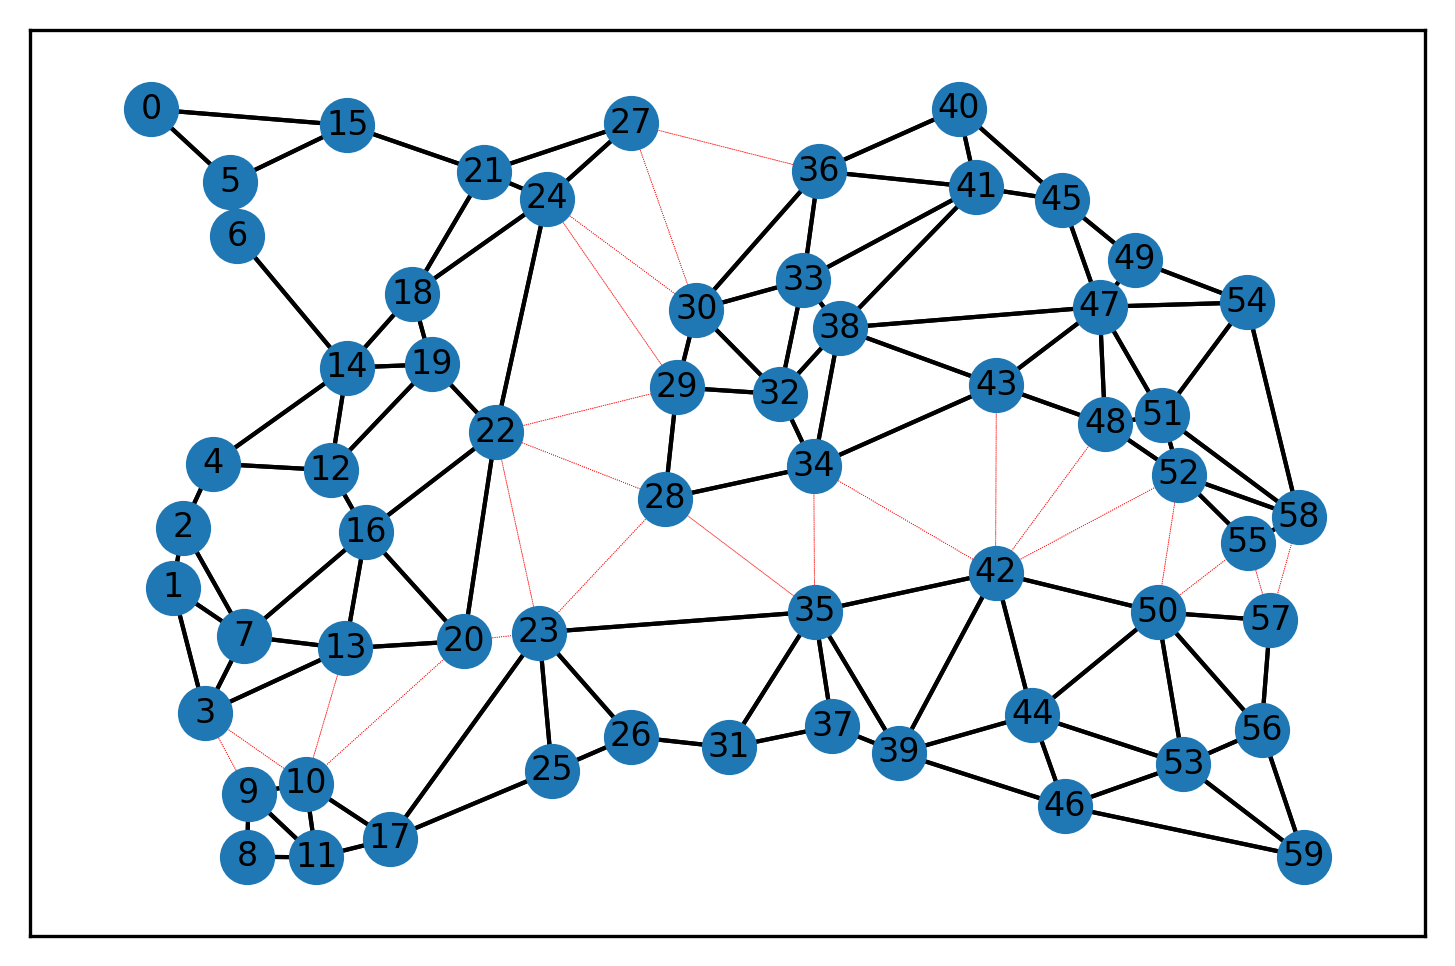

In [280]:
def main():
    # create a folder named data in the same folder as the source code and
    # place the three data files there.
    ADJ_MATRIX_PATH = "adjacency_matrix.txt"
    COORDINATES_PATH = "coordinates.txt"
    PARTY_POP_PATH = "party_pop.txt"
    DISTRICT_ASSIGNMENT_PATH = "district_assignment.txt"
    
    initial_plan = Plan()
    initial_plan.load_graph_from_file(ADJ_MATRIX_PATH)
    initial_plan.load_coordinates_from_file(COORDINATES_PATH)
    initial_plan.load_populations_from_file(PARTY_POP_PATH)
    initial_plan.load_plan_from_file(DISTRICT_ASSIGNMENT_PATH)
    
  
    nodes = []
    num_nodes = []
    district_sum = []
    republican_sum = []
    democrat_sum = []
    
    # Print Number of Districts
    print("Number of Districts:", len(initial_plan.districts))
    
    # Print Number of Nodes per District
    for i in initial_plan.district_nodes.keys():
        nodes.append(initial_plan.district_nodes[i])
    for i in nodes:
        num_nodes.append(len(i))
    
    nodes_data_frame = pd.DataFrame([num_nodes], columns = ["District 0", "District 1", "District 2"])  
    print(nodes_data_frame)
    
    # Find number of Republicans, Democrats and Population per district
    for i in range(3):
        thesum = 0
        rep_sum = 0
        dem_sum = 0
        for j in range(len(nodes[i])):
               
            rep_sum += initial_plan.node_populations[nodes[i][j]][0]
            dem_sum += initial_plan.node_populations[nodes[i][j]][1]
            thesum += initial_plan.node_populations[nodes[i][j]][2]
        district_sum.append(thesum)
        republican_sum.append(rep_sum)
        democrat_sum.append(dem_sum)
    
    #Create a data frame which summarises the population, republlicans and democrats per district
    df = pd.DataFrame([republican_sum, democrat_sum, district_sum], columns = initial_plan.districts)
    rows = ["Republicans", "Democrats", "Total Population"]
    df = df.rename(index = dict(enumerate(rows)))
    print(df)
    print()
    # Print initial plan lectoral Competitiveness
    print("Electoral Competitiveness", initial_plan.compute_electoral_competitiveness())
    
    # Show the Initial Plan
    initial_plan.show_plan()
if __name__ == "__main__":
    main()




# Sampling

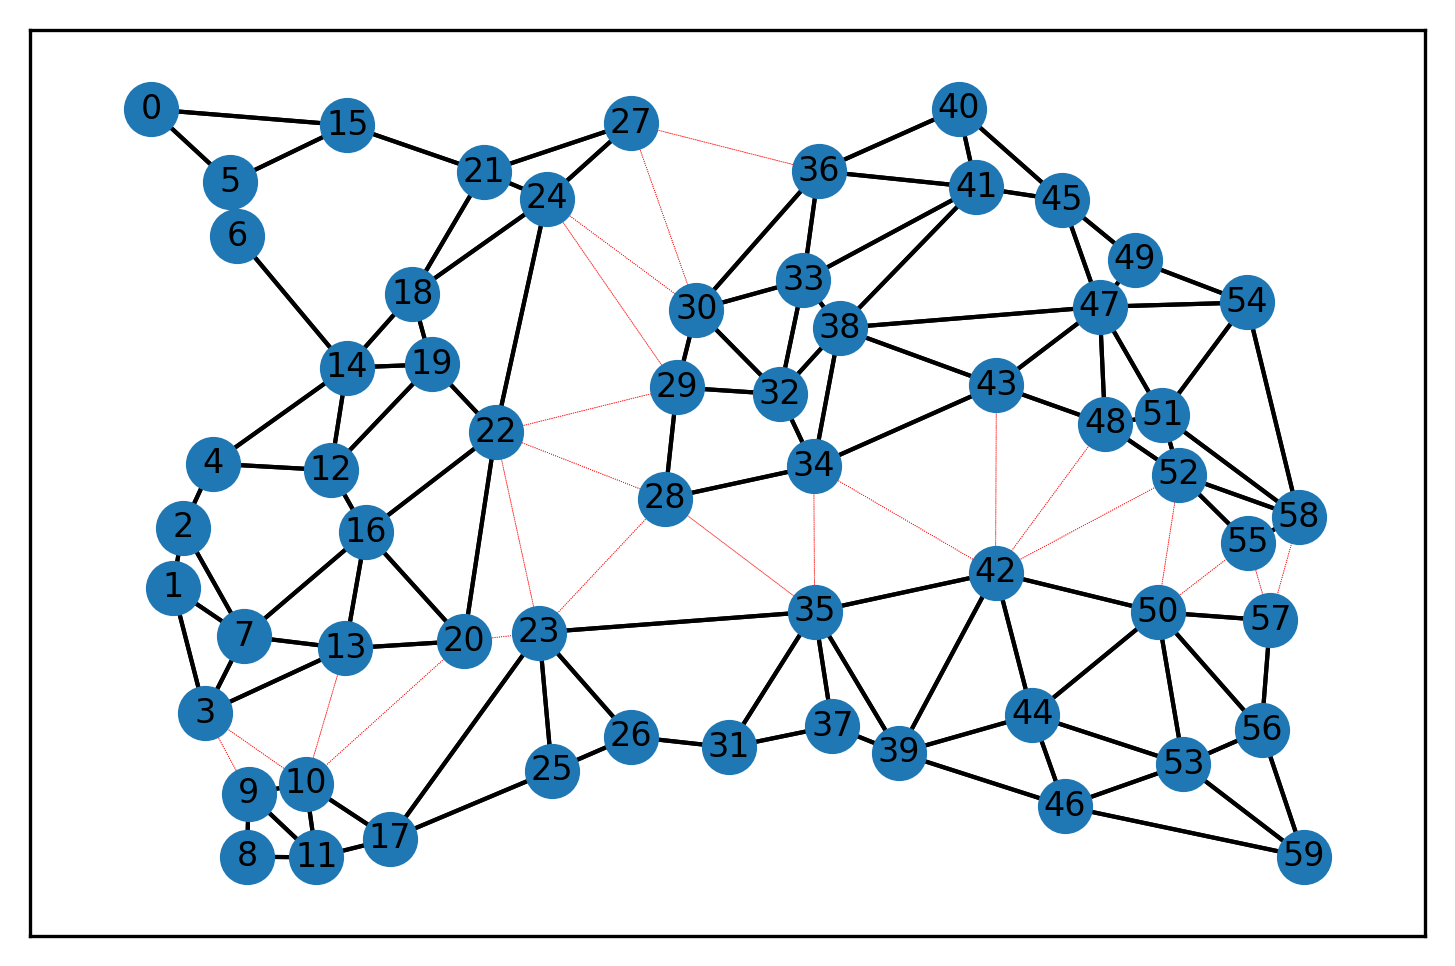

1
Execution time: 3873.417854309082 seconds.


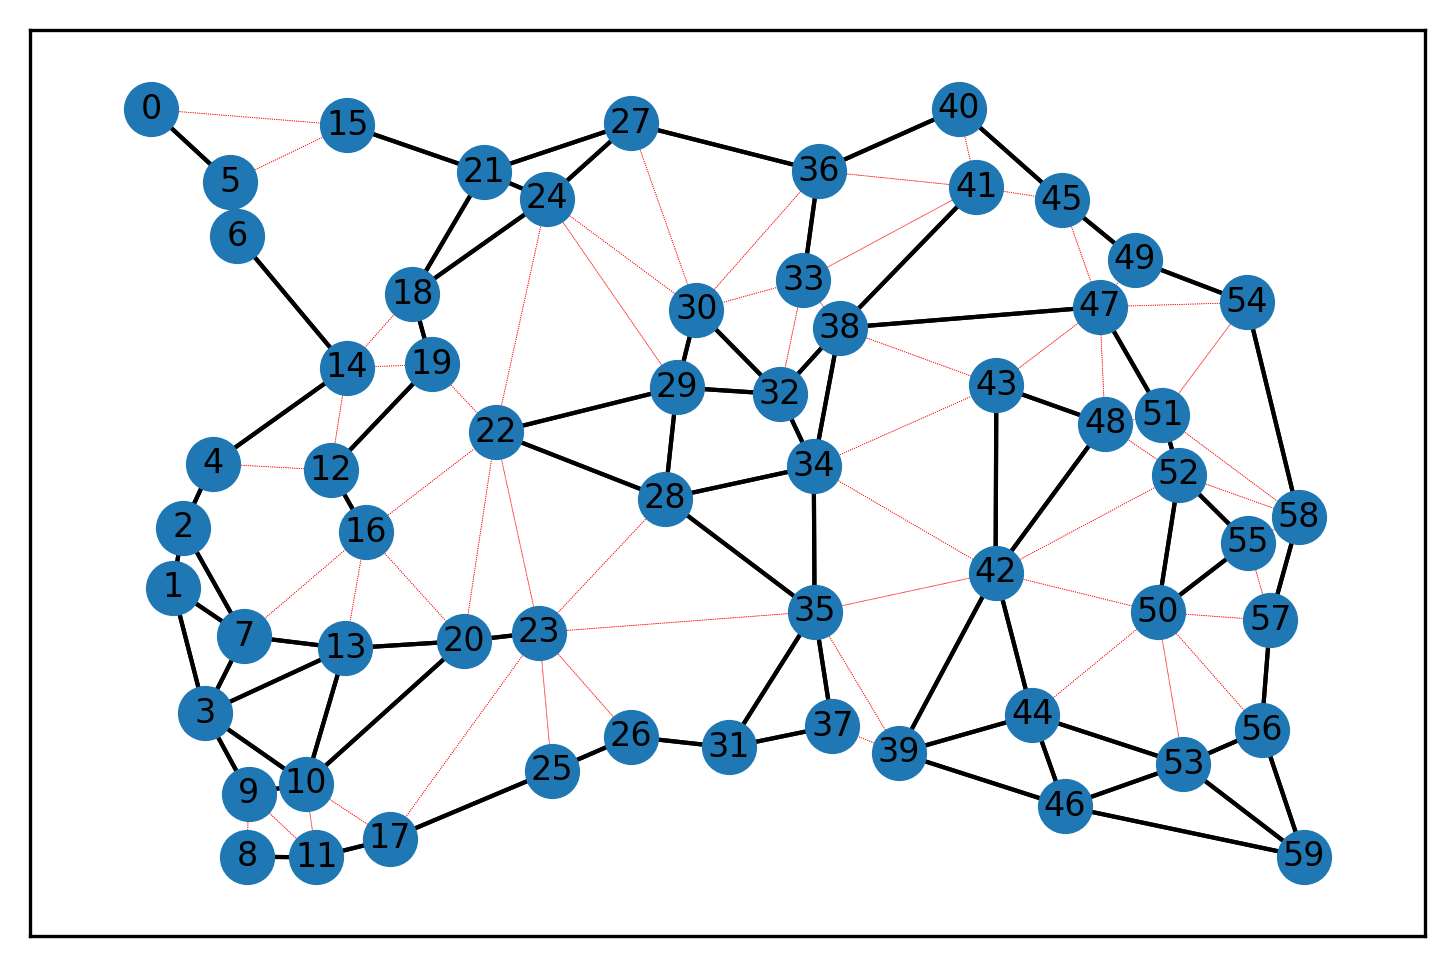

In [289]:
##############################################################################
## The main() function is where all your commands go.
## So far all it does is load the three data files and visualize the Plan.
##############################################################################
def main():
    
    start_time = time.time()
    # create a folder named data in the same folder as the source code and
    # place the three data files there.
    ADJ_MATRIX_PATH = "adjacency_matrix.txt"
    COORDINATES_PATH = "coordinates.txt"
    PARTY_POP_PATH = "party_pop.txt"
    DISTRICT_ASSIGNMENT_PATH = "district_assignment.txt"
    
    initial_plan = Plan()
    initial_plan.load_graph_from_file(ADJ_MATRIX_PATH)
    initial_plan.load_coordinates_from_file(COORDINATES_PATH)
    initial_plan.load_populations_from_file(PARTY_POP_PATH)
    initial_plan.load_plan_from_file(DISTRICT_ASSIGNMENT_PATH)
    
    # Define Sample Size and create Redistricter object
    sample_size = 1000
    plan = Redistricter()
    plan.set_initial_plan(initial_plan)
    plan.initial_plan.show_plan()
    
    # Define Storage Arrays
    plan_array  = []
    weights     = []
    resampling  = []
    
    # Perform 1000 transitions to get a Plan to be included in the sample
    for t in range(sample_size):
        plan = Redistricter()
        plan.set_initial_plan(initial_plan)
        for j in range(1000):
            plan.perform_transition(5)
        
           
        
        plan_array.append(deepcopy(plan.current_plan))
        
        # Weigh the plans with 1/g_beta
        weights.append(1/plan.current_plan.compute_gibbs_distribution())
    
    # Get the position of the plans that are resampled
    nums = np.arange(sample_size)
    position = random.choices(list(nums), weights, k=sample_size)
    
    # Resampling
    for i in position:
        resampling.append(deepcopy(plan_array[i]))
    
    print(len(resampling)) 
    
    # Calculate Run Time
    end_time = time.time()
    runtime = end_time - start_time
    print(f"Execution time: {runtime*1000} seconds.")
    
    for i in resampling:
        i.show_plan()
if __name__ == "__main__":
    main()




# Electoral Competitiveness

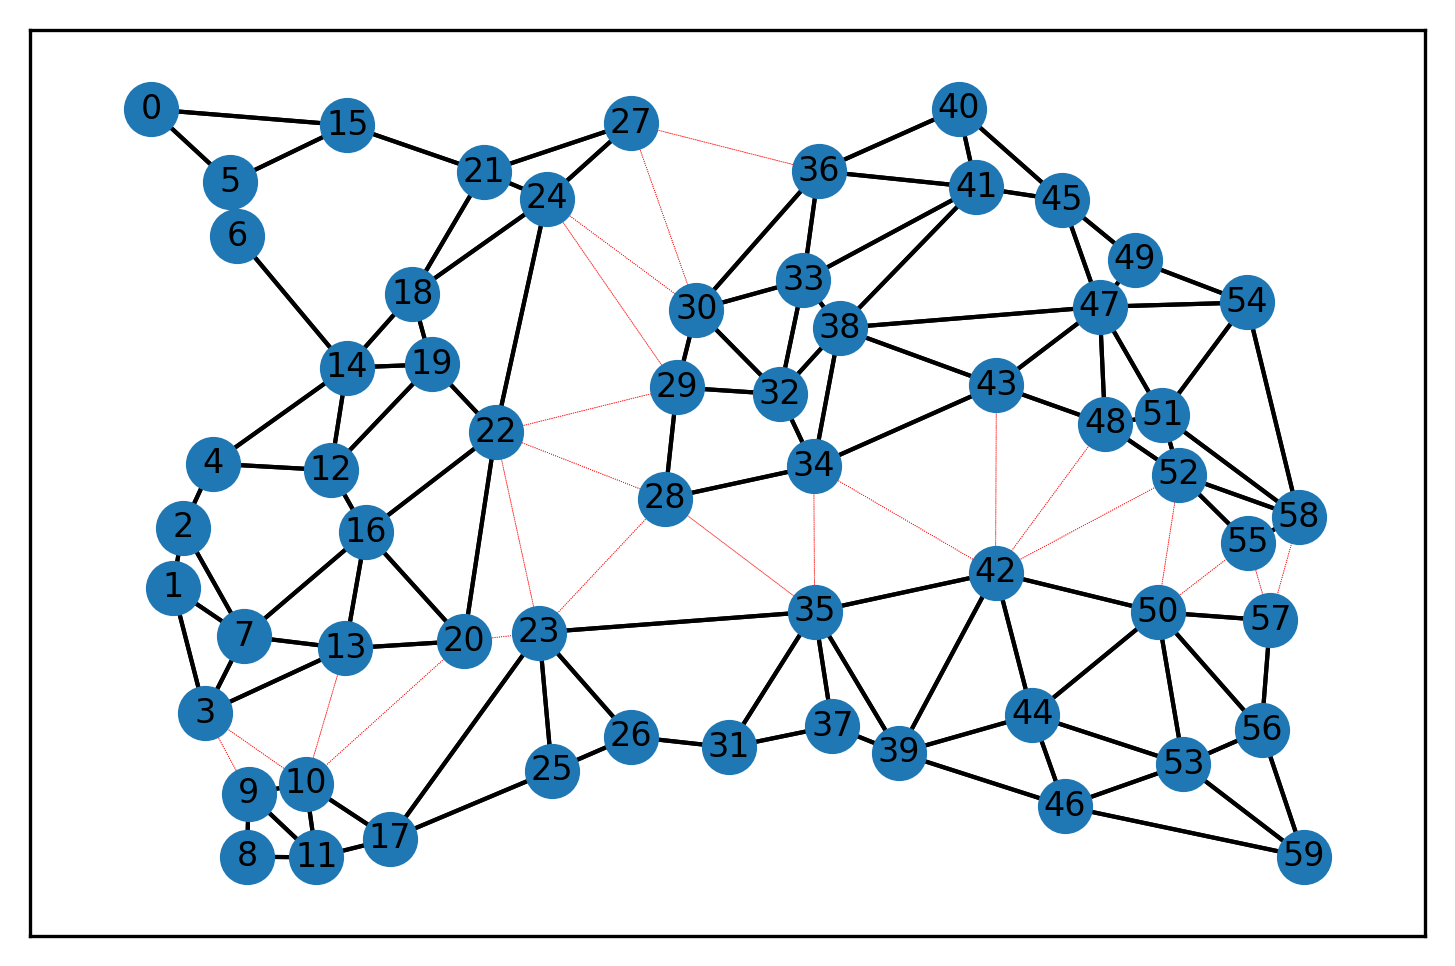

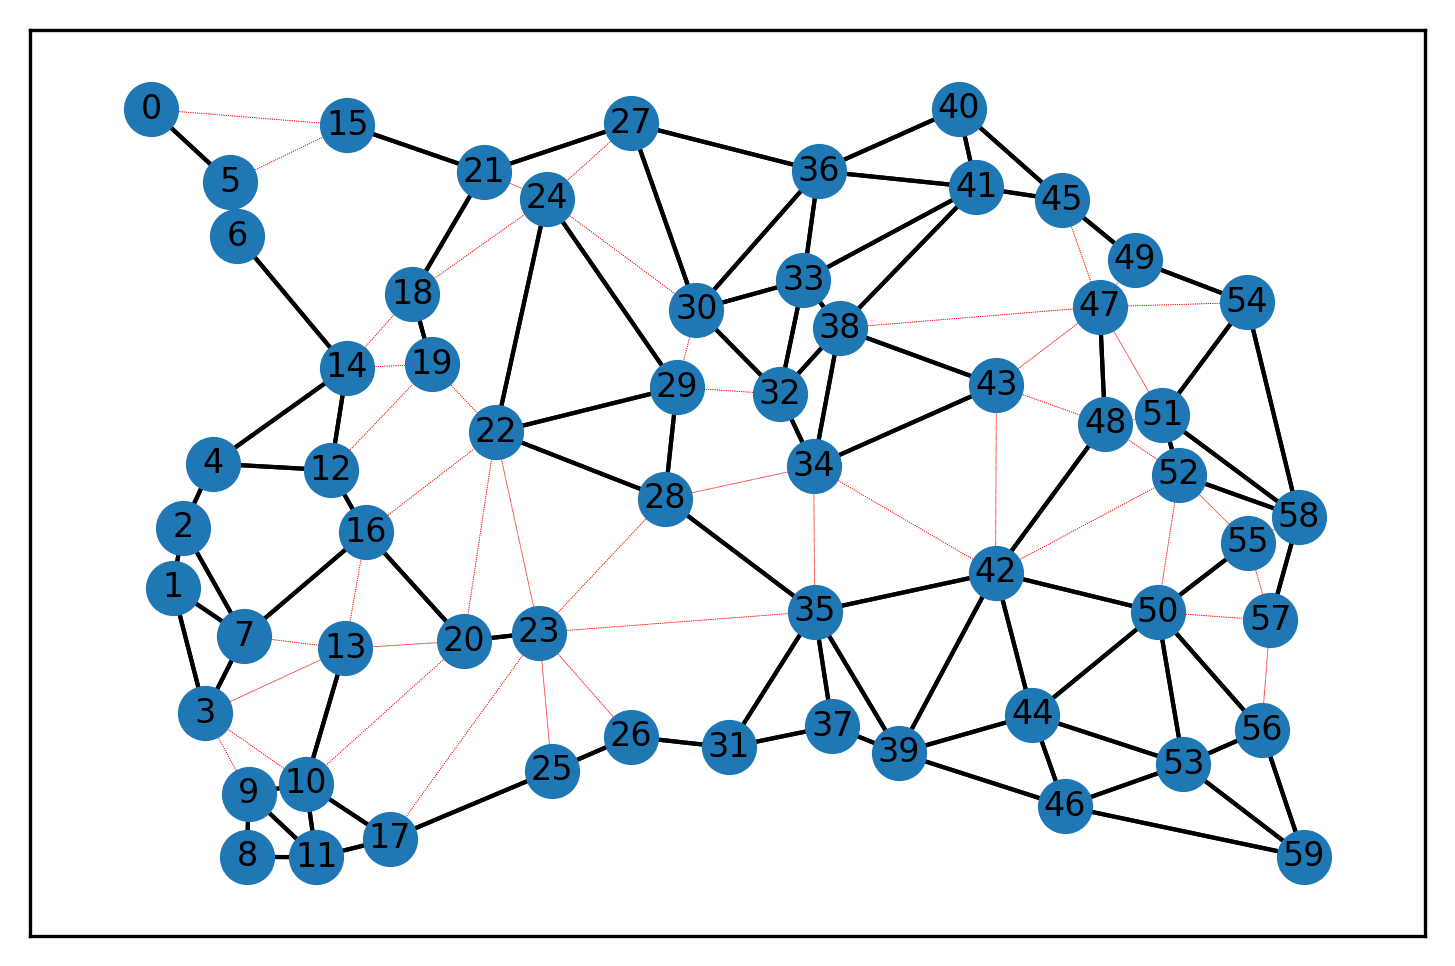

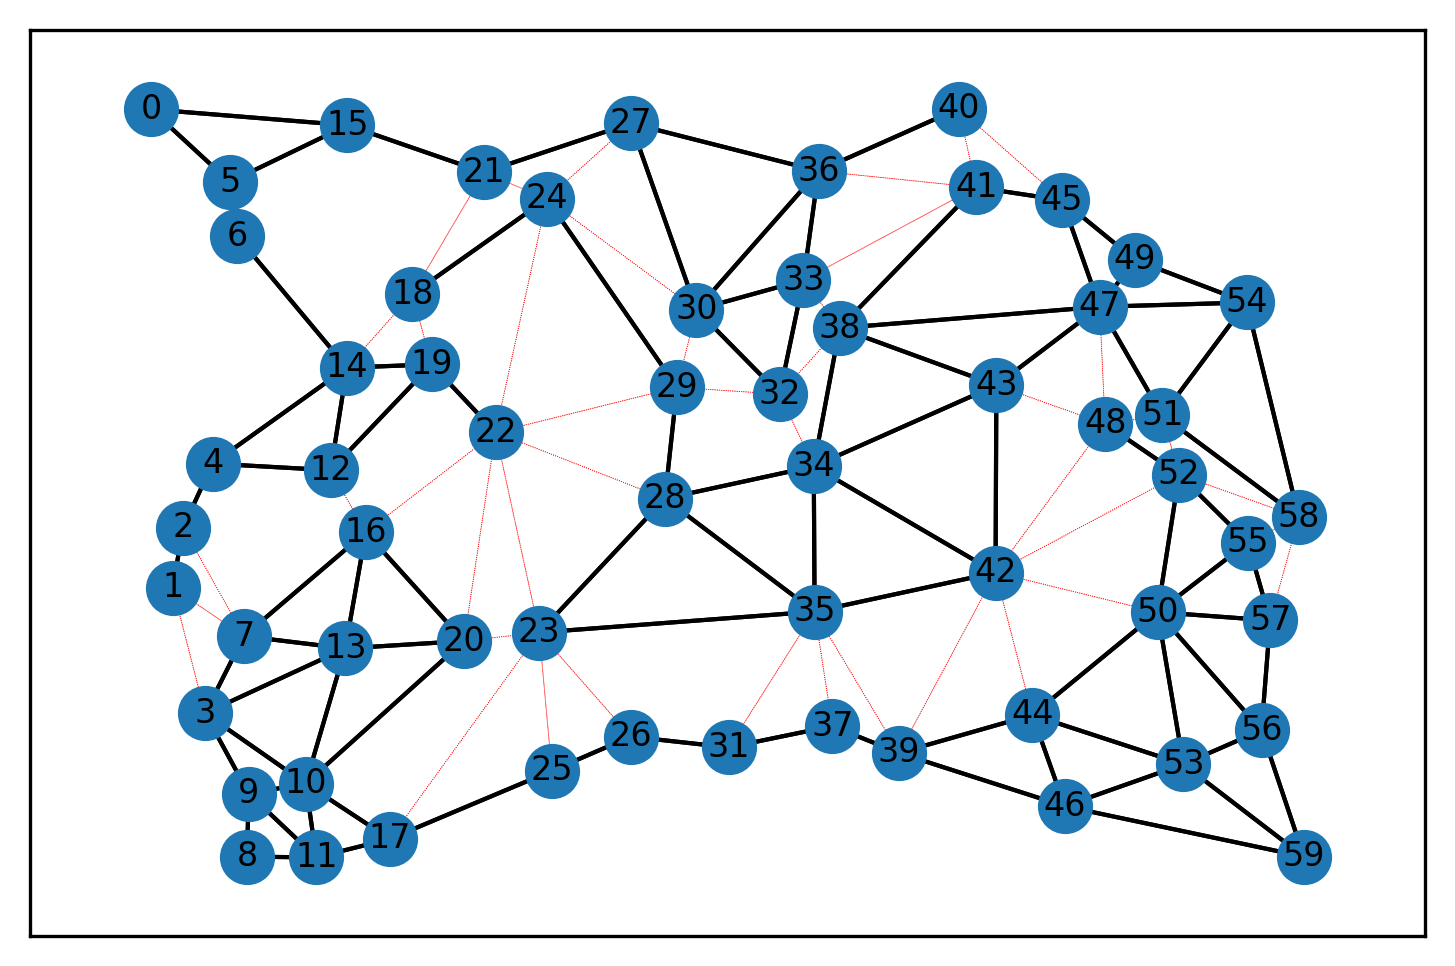

Minimum Electoral Competitiveness 0.8513151876059066 Index: 77
Minimum district size 13 Index: 20


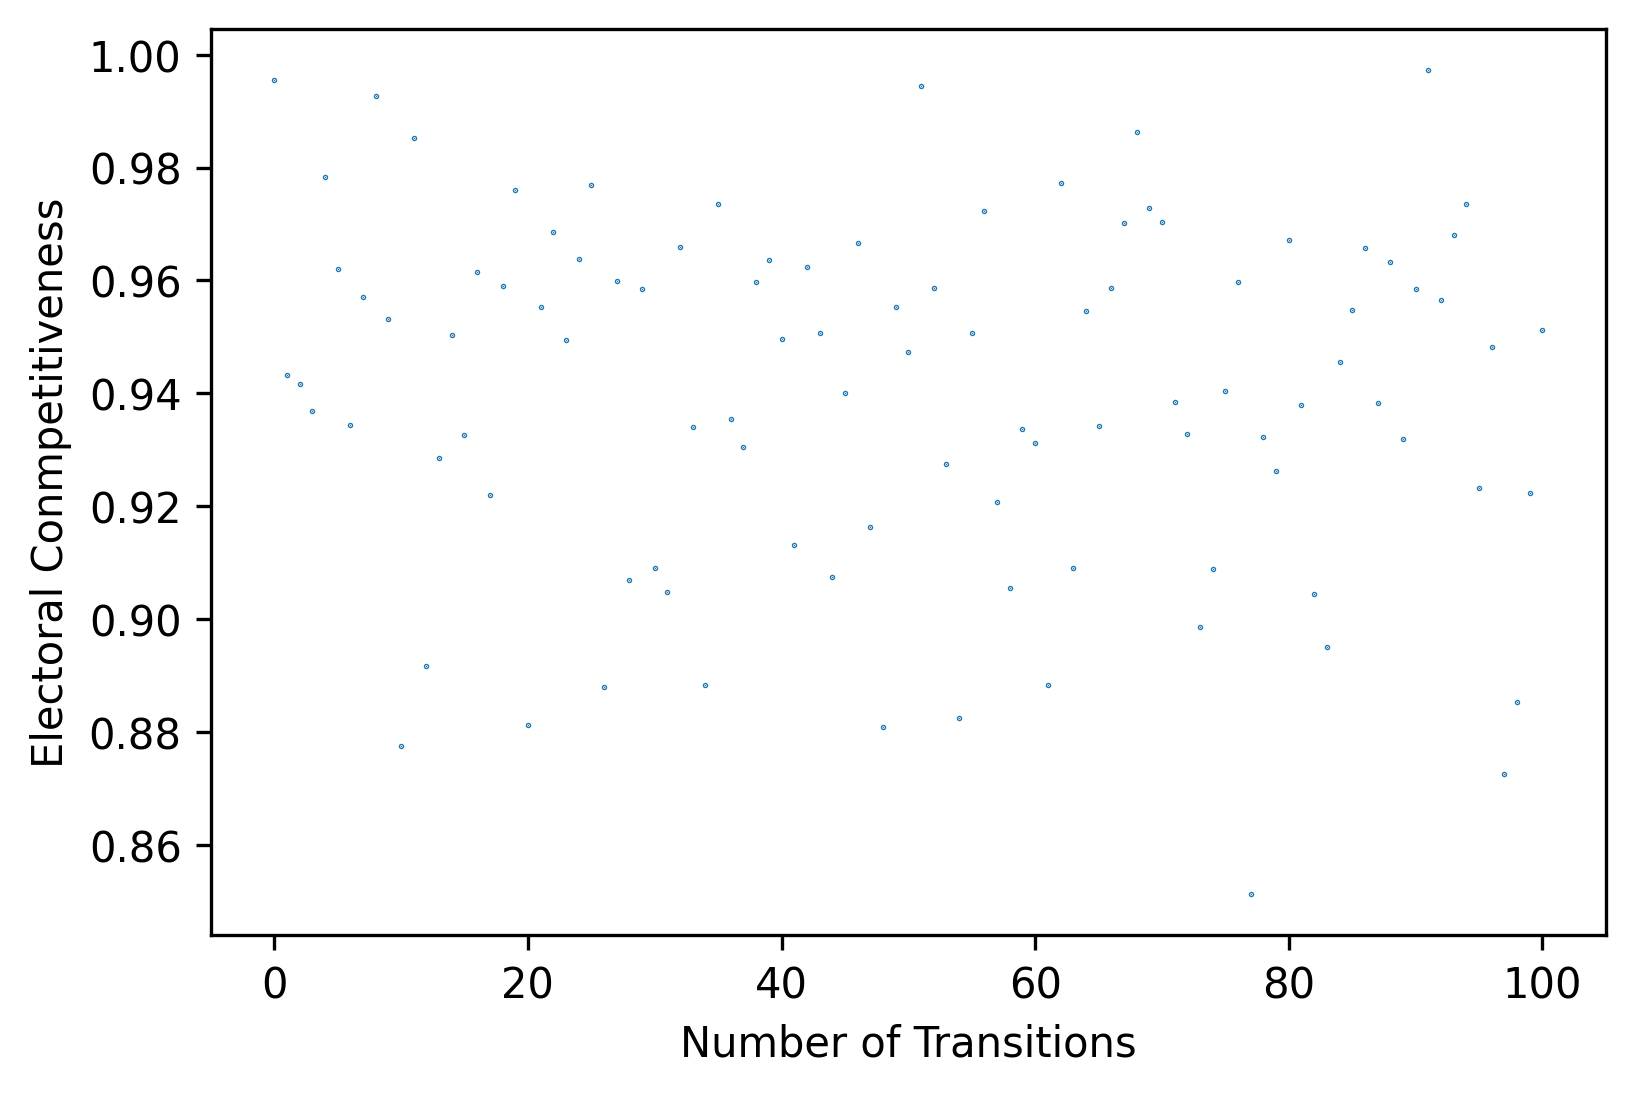

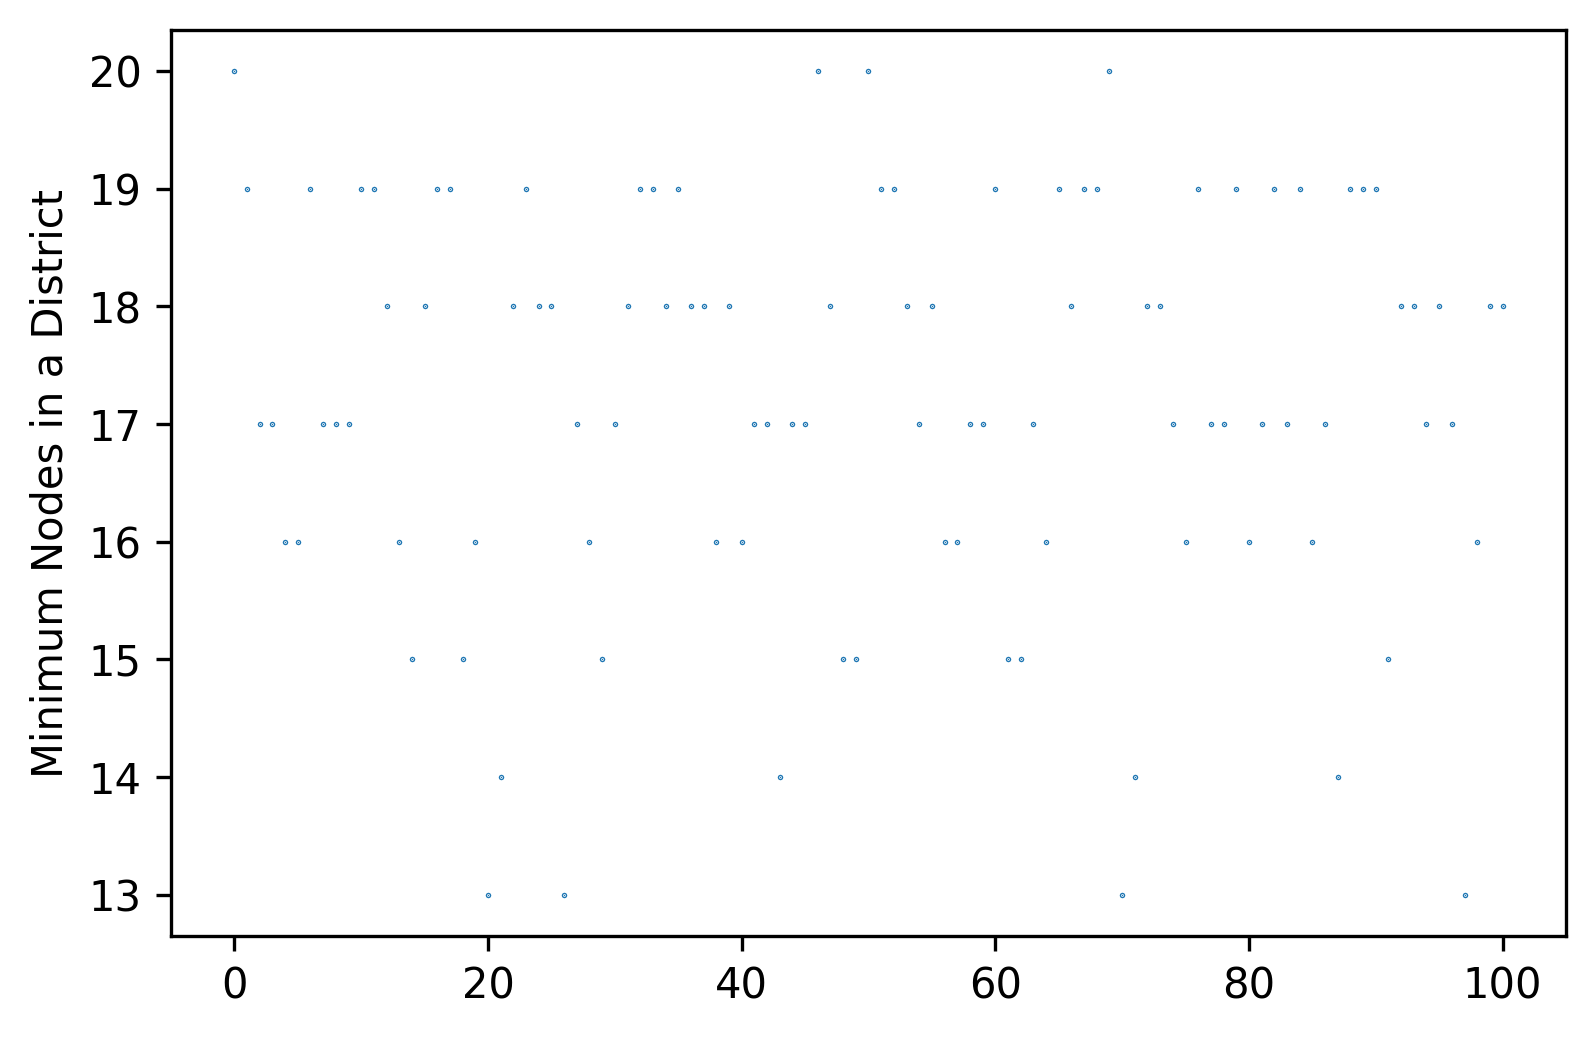

In [440]:
##############################################################################
## The main() function is where all your commands go.
## So far all it does is load the three data files and visualize the Plan.
##############################################################################
def main():
    # create a folder named data in the same folder as the source code and
    # place the three data files there.
    ADJ_MATRIX_PATH = "adjacency_matrix.txt"
    COORDINATES_PATH = "coordinates.txt"
    PARTY_POP_PATH = "party_pop.txt"
    DISTRICT_ASSIGNMENT_PATH = "district_assignment.txt"
    
    initial_plan = Plan()
    initial_plan.load_graph_from_file(ADJ_MATRIX_PATH)
    initial_plan.load_coordinates_from_file(COORDINATES_PATH)
    initial_plan.load_populations_from_file(PARTY_POP_PATH)
    initial_plan.load_plan_from_file(DISTRICT_ASSIGNMENT_PATH)
    
    # Set Variables
    sample_size = 100
    num_transitions = 100
    beta = 5
    plan_array  = []
    weights     = []
    resampling  = []
    ec = []
    min_district = []
    # Create Redistricter Object and show the initial Plan
    plan = Redistricter()
    plan.set_initial_plan(initial_plan)
    plan.initial_plan.show_plan()
    plan_array.append(deepcopy(plan.initial_plan))
    
    # First loop loops over the number of objects we'll have in the sample
    ec.append(plan.current_plan.compute_electoral_competitiveness())
    min_district.append(get_min_district_size(plan.current_plan))
    for t in range(sample_size):
        plan = Redistricter()
        plan.set_initial_plan(initial_plan)
        
        
        # Loop over the number of transitions to get a plan and compute ec of the object
        for j in range(num_transitions):
            plan.perform_transition(beta)
        plan_array.append(deepcopy(plan.current_plan))
        ec.append(plan.current_plan.compute_electoral_competitiveness())
        min_district.append(get_min_district_size(plan.current_plan))
    
    # Find the Plan with the lowest Nodes in District
    min_dist = min(min_district)
    min_dist_index = min_district.index(min_dist)
    plan_array[min_dist_index].show_plan()
    
    # Find the Plan with the lowest Electoral Competitiveness
    min_ec = min(ec)
    min_index = ec.index(min_ec)
    plan_array[min_index].show_plan()
    
    print("Minimum Electoral Competitiveness", min(ec), "Index:", min_index)
    print("Minimum district size", min(min_district), "Index:", min_dist_index)
    # Plot electoral competitiveness vs number in transition
    plt.scatter(list(np.arange(sample_size+1)), ec, s=.1)
    plt.xlabel("Number of Transitions")
    plt.ylabel("Electoral Conmpetitiveness")
    plt.show()
    
    # Plot Minimum District per transition
    plt.scatter(list(np.arange(sample_size+1)), min_district, s=.1)
    #plt.xlabel("Number of Transitions")
    plt.ylabel("Minimum Nodes in a District")
    plt.show()
if __name__ == "__main__":
    main()


# Tunning Beta

                    0.001      0.500      1.000      4.000      5.000    \
Pv                 0.350000   0.450000   0.450000   0.300000   0.200000   
EC                 0.914239   0.933313   0.957341   0.938494   0.909728   
Minimum District  13.000000  11.000000  12.000000  16.000000  17.000000   

                   10.000     20.000     80.000     100.000  
Pv                 0.15000   0.000000   0.000000   0.000000  
EC                 0.91541   0.901093   0.995515   0.995515  
Minimum District  17.00000  20.000000  20.000000  20.000000  


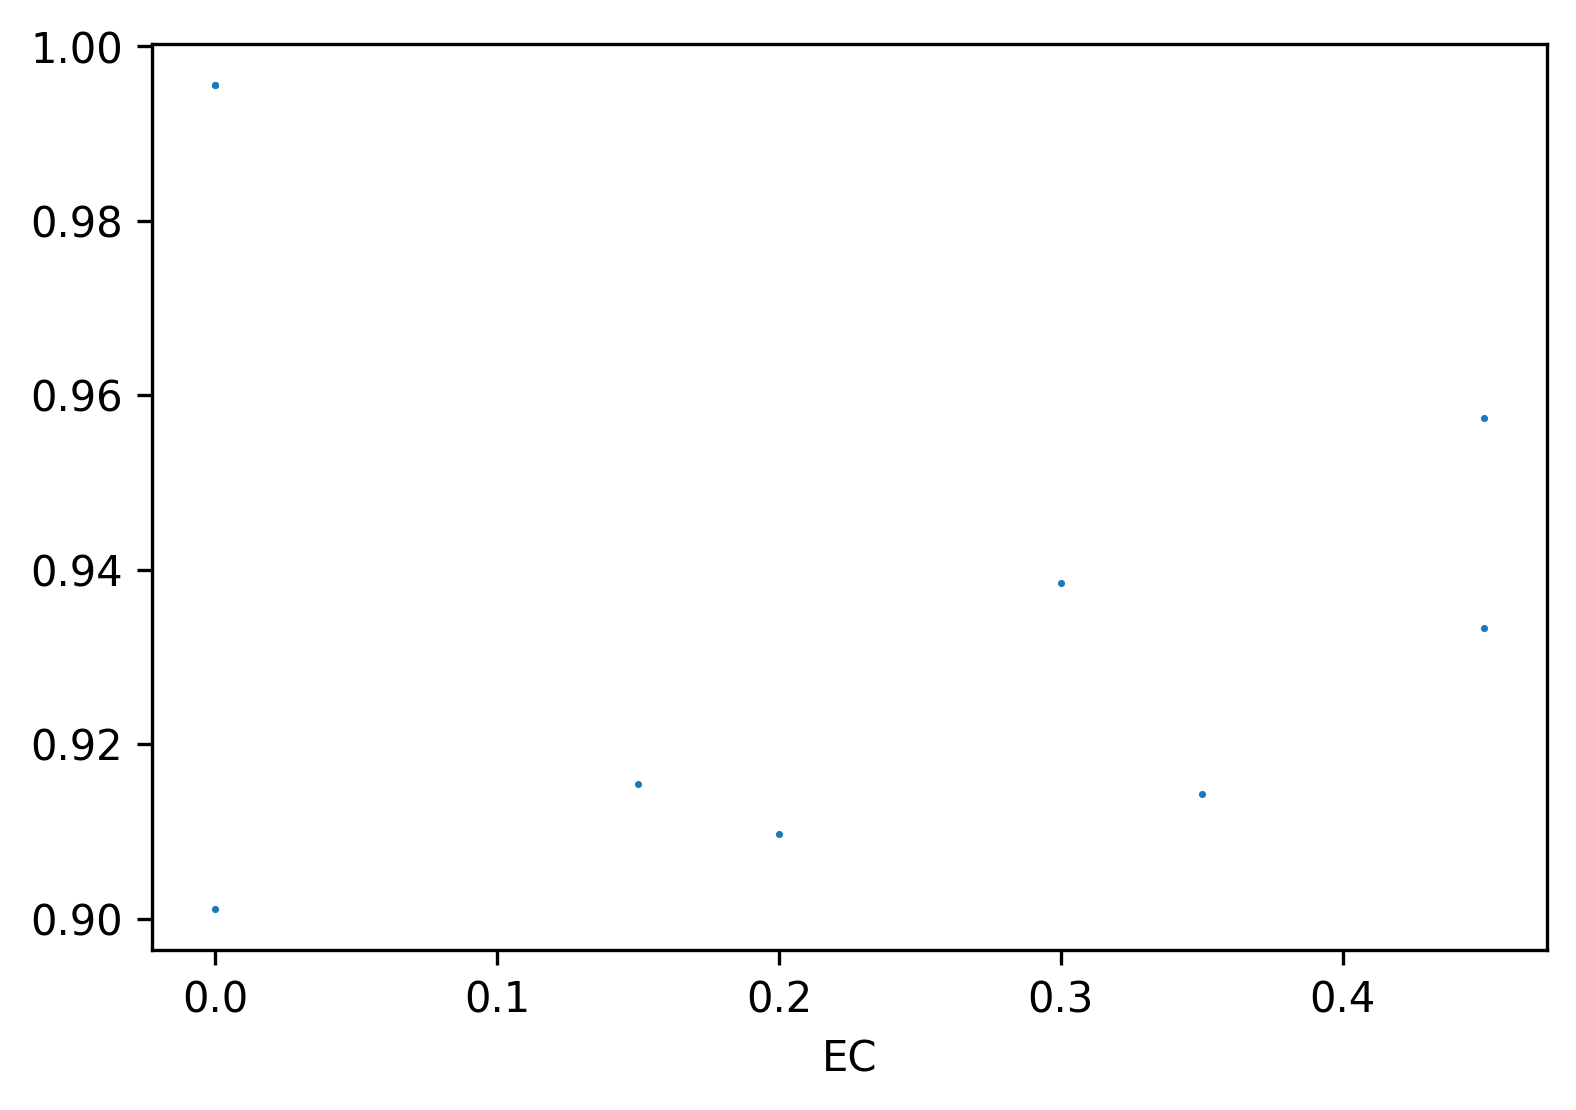

In [425]:
##############################################################################
## The main() function is where all your commands go.
## So far all it does is load the three data files and visualize the Plan.
##############################################################################
def main():
    # create a folder named data in the same folder as the source code and
    # place the three data files there.
    ADJ_MATRIX_PATH = "adjacency_matrix.txt"
    COORDINATES_PATH = "coordinates.txt"
    PARTY_POP_PATH = "party_pop.txt"
    DISTRICT_ASSIGNMENT_PATH = "district_assignment.txt"
    
    initial_plan = Plan()
    initial_plan.load_graph_from_file(ADJ_MATRIX_PATH)
    initial_plan.load_coordinates_from_file(COORDINATES_PATH)
    initial_plan.load_populations_from_file(PARTY_POP_PATH)
    initial_plan.load_plan_from_file(DISTRICT_ASSIGNMENT_PATH)
    
    
    
    
    plan = Redistricter()
    plan.set_initial_plan(initial_plan)
    #plan.initial_plan.show_plan()
    betas = [.001,.5,1,4,5,10,20,80,100]

    sample_size = 10
    pv_array = []
    ec = []
    district_size = []
    for i in betas:
    
        for j in range(sample_size):
            plan = Redistricter()
            plan.set_initial_plan(initial_plan)
            temp_ec = []
            temp_pv = []
            temp_size = []
            for k in range(100):
                plan.perform_transition(i)
         
            temp_ec.append(plan.current_plan.compute_electoral_competitiveness())
            temp_pv.append(pv(plan.current_plan))
            temp_size.append(get_min_district_size(plan.current_plan))
        ec.append(sum(temp_ec)/len(temp_ec))
        pv_array.append(sum(temp_pv)/len(temp_pv))
        district_size.append(sum(temp_size)/len(temp_size))
    df = pd.DataFrame([pv_array, ec,district_size], columns = betas)
    rows = ["Pv", "EC","Minimum District"]
    df = df.rename(index = dict(enumerate(rows)))
    print(df)
    
    
    plt.scatter(pv_array,ec, s=.5)
    plt.xlabel("Pv")
    plt.xlabel("EC")
    plt.show()
    ## How to tune beta?
    # run Redistricter 5000 times
    # possible move: compute P_v for each of the 5000 plans
    # for this, adapt the Gibbs distribution method
    # alternative move: note the minimum district size (# nodes) in each plan


##############################################################################
## Run the main() function
##############################################################################

if __name__ == "__main__":
    main()



# Load Plan

In [392]:
ADJ_MATRIX_PATH = "adjacency_matrix.txt"
COORDINATES_PATH = "coordinates.txt"
PARTY_POP_PATH = "party_pop.txt"
DISTRICT_ASSIGNMENT_PATH = "district_assignment.txt"
    
initial_plan = Plan()
initial_plan.load_graph_from_file(ADJ_MATRIX_PATH)
initial_plan.load_coordinates_from_file(COORDINATES_PATH)
initial_plan.load_populations_from_file(PARTY_POP_PATH)
initial_plan.load_plan_from_file(DISTRICT_ASSIGNMENT_PATH)
    
plan = Redistricter()
plan.set_initial_plan(initial_plan)

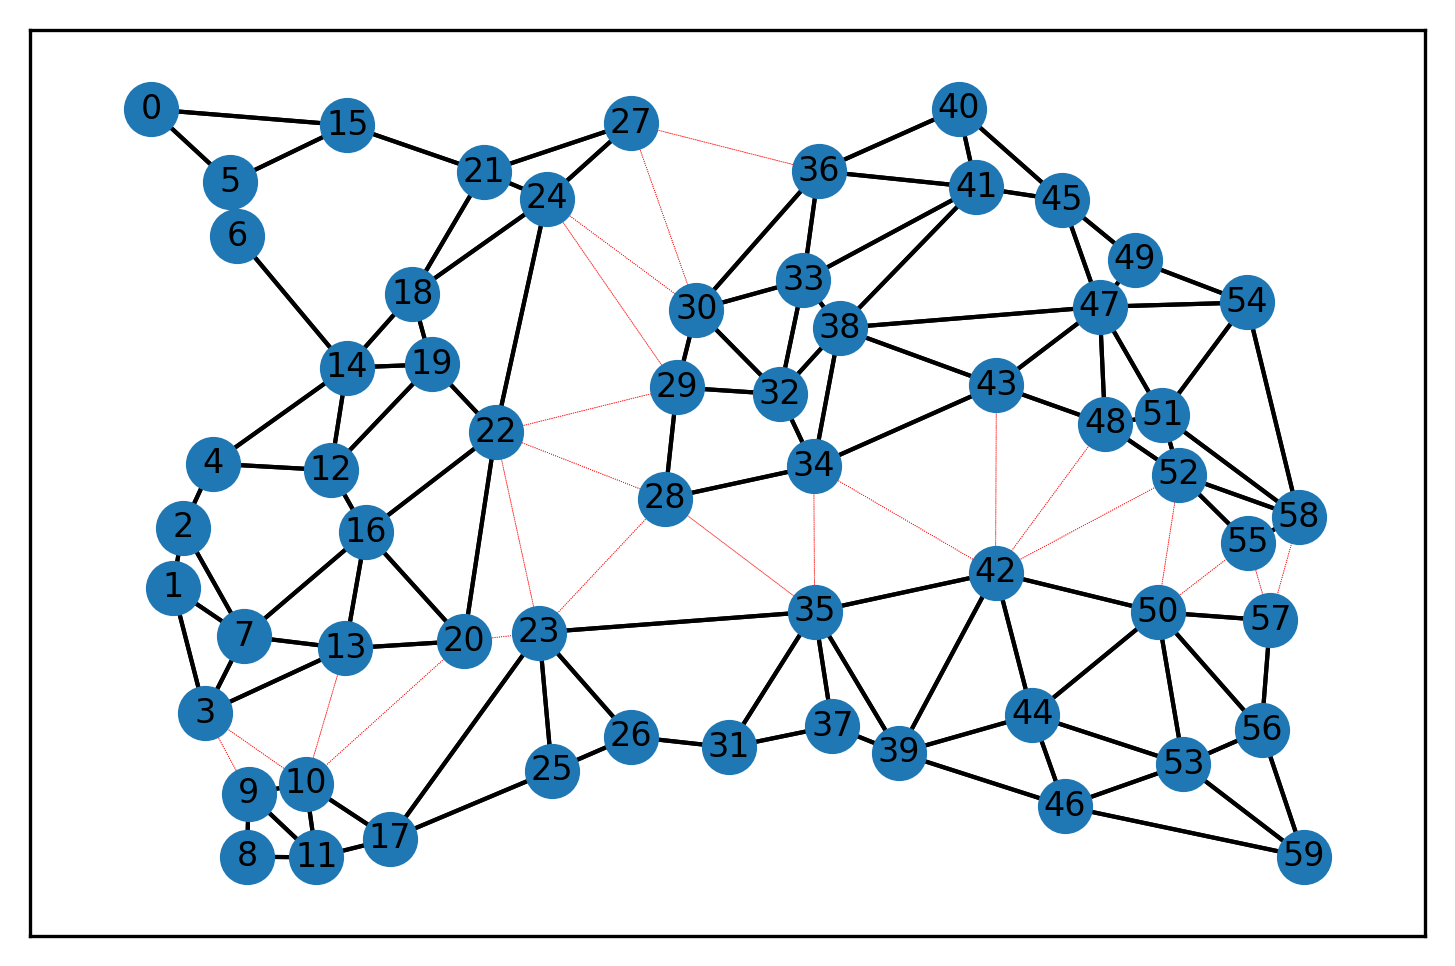

In [396]:
plan.current_plan.show_plan()

# Calculating Population Equality Constraint Pv

In [295]:
def pv(plan):
    nodes = []
    p_hat = 60000
    nodes =[]
    district_sum = []
    
    for i in plan.district_nodes.keys():
        nodes.append(plan.district_nodes[i])
   
    for i in range(3):
        thesum = 0
        for j in range(len(nodes[i])):
           
            thesum += plan.node_populations[nodes[i][j]][2]
        district_sum.append(thesum)
    district_sum = np.array(district_sum)
    max_pv = max(abs((district_sum / (p_hat/3))-1))
    return max_pv
    

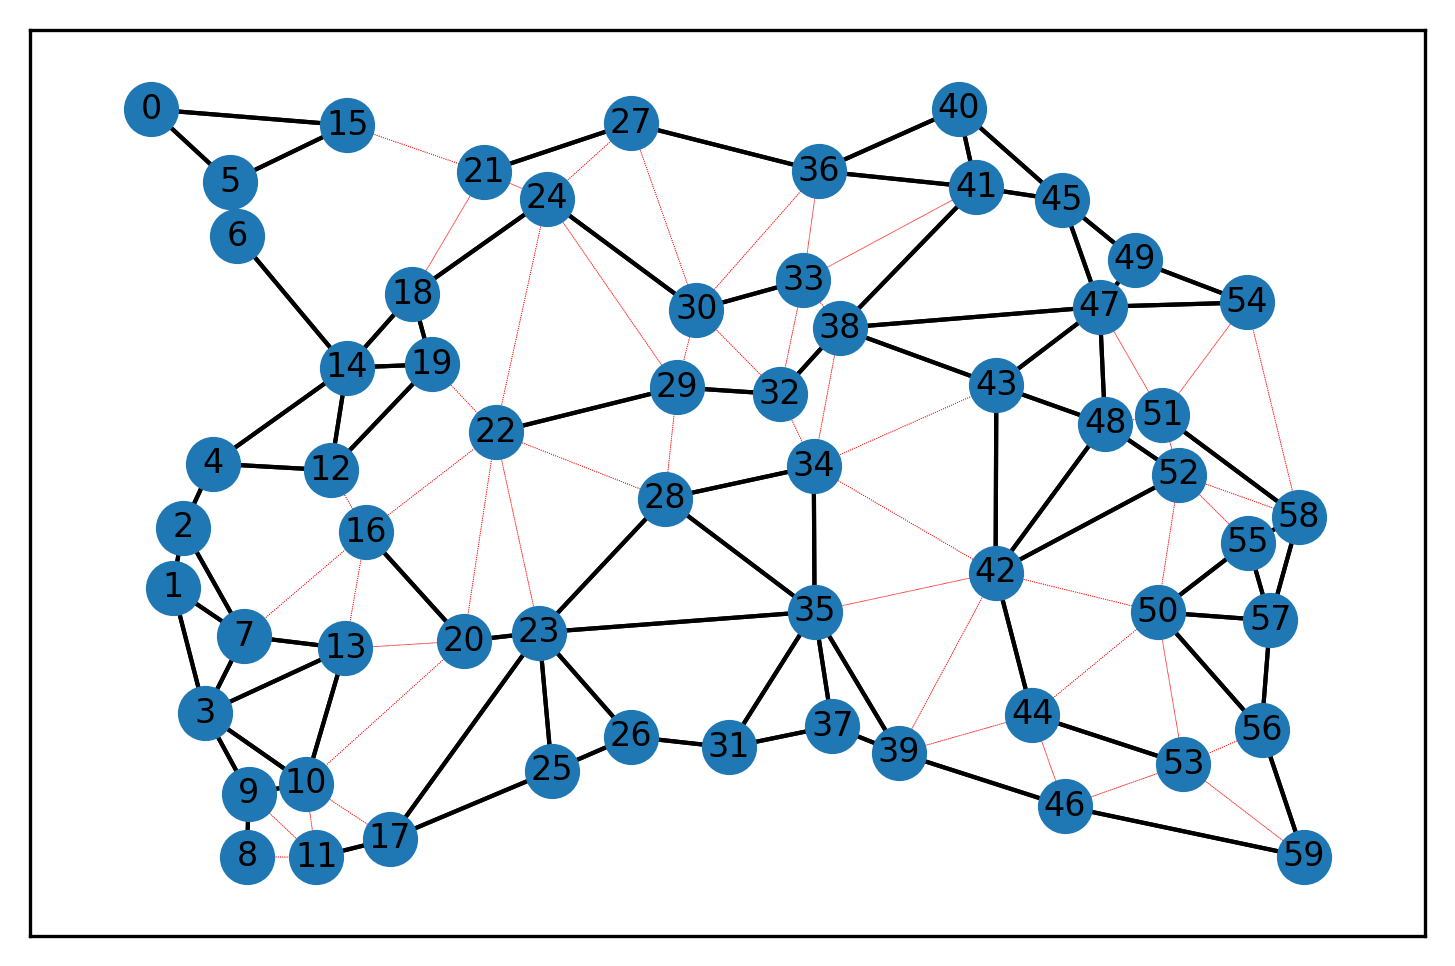

19


0.050000000000000044

In [378]:
plan.current_plan.show_plan()
print(get_min_district_size(plan.current_plan))
pv(plan.current_plan)

# Minimum District Size

In [146]:
def get_min_district_size(plan):
    nodes = []
    num_nodes = []
    
    for i in plan.district_nodes.keys():
        nodes.append(plan.district_nodes[i])
   
    for j in range(3):
        num_nodes.append(len(nodes[j]))
    return min(num_nodes)

In [362]:
plan.perform_transition(5)
get_min_district_size(plan.current_plan)

19